In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
import satpass


In [3]:
domain = (145,160,-59,-51)
sw = satpass.NominalTrack(mission='sw') # "swi" for fast sampling phase

### Spatial selection only

##### using select_in_area() function

In [4]:
#### Science phase

swot_tracks = sw.select_in_area(domain) # Nominal swot tracks in the domain, contain few lon/lat points to plot tracks
swot_tracks  # track / lon / lat

,track,lon,lat
1873,4,153.271524,-51.101563
1874,4,153.444136,-51.444395
1875,4,153.619779,-51.786936
1876,4,153.798474,-52.129058
1877,4,153.980331,-52.470806
...,...,...,...
276553,560,158.909141,-56.538602
276554,560,159.141034,-56.874411
276555,560,159.377588,-57.209657
276556,560,159.618940,-57.544324


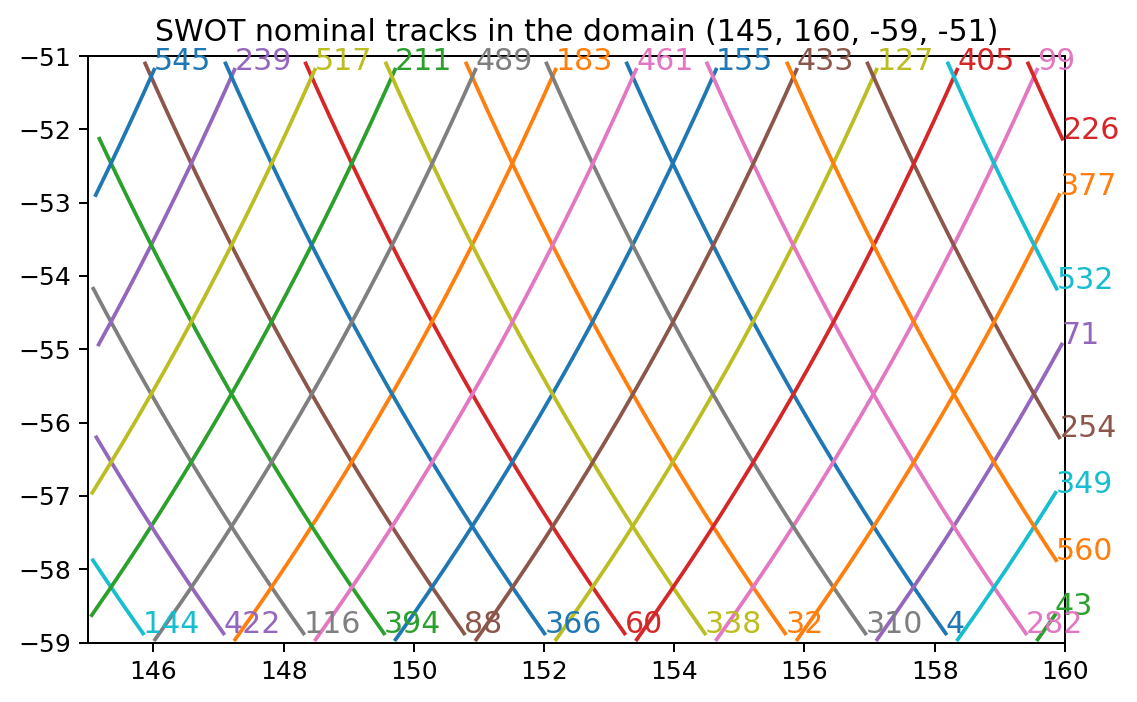

In [5]:
plt.figure(figsize = (12, 4), dpi = 180)

plt.subplot(121)
swot_tracks = sw.select_in_area(domain)

for n in np.unique(swot_tracks.track):
    
    track = swot_tracks[swot_tracks.track == n]
    im =plt.plot(track.lon, track.lat)[0]
    c = im.get_color()
    plt.text(track.lon.values[-1], track.lat.values[-1], n, c = c, fontsize = 12)

plt.title(f'SWOT nominal tracks in the domain {domain}')
plt.xlim(domain[:2])
plt.ylim(domain[2:])

plt.tight_layout()

### Spatio-temporal selection
##### sat_pass() function

In [7]:
nt = sw
date_range = [pd.Timestamp('2023-11-13'), pd.Timestamp('2023-11-17')]
swot_passes = satpass.sat_pass('sw', date_range, domain) # Actual swot passes that pass in the region during the given time interval

swot_passes

,track,direction,cycle,time
2023-11-13 14:58:00,310,des,6.0,2023-11-13 14:58:00
2023-11-14 14:59:00,338,des,6.0,2023-11-14 14:59:00
2023-11-14 23:51:00,349,asc,6.0,2023-11-14 23:51:00
2023-11-15 14:59:00,366,des,6.0,2023-11-15 14:59:00
2023-11-15 23:53:00,377,asc,6.0,2023-11-15 23:53:00
2023-11-16 15:00:00,394,des,6.0,2023-11-16 15:00:00
2023-11-16 23:53:00,405,asc,6.0,2023-11-16 23:53:00


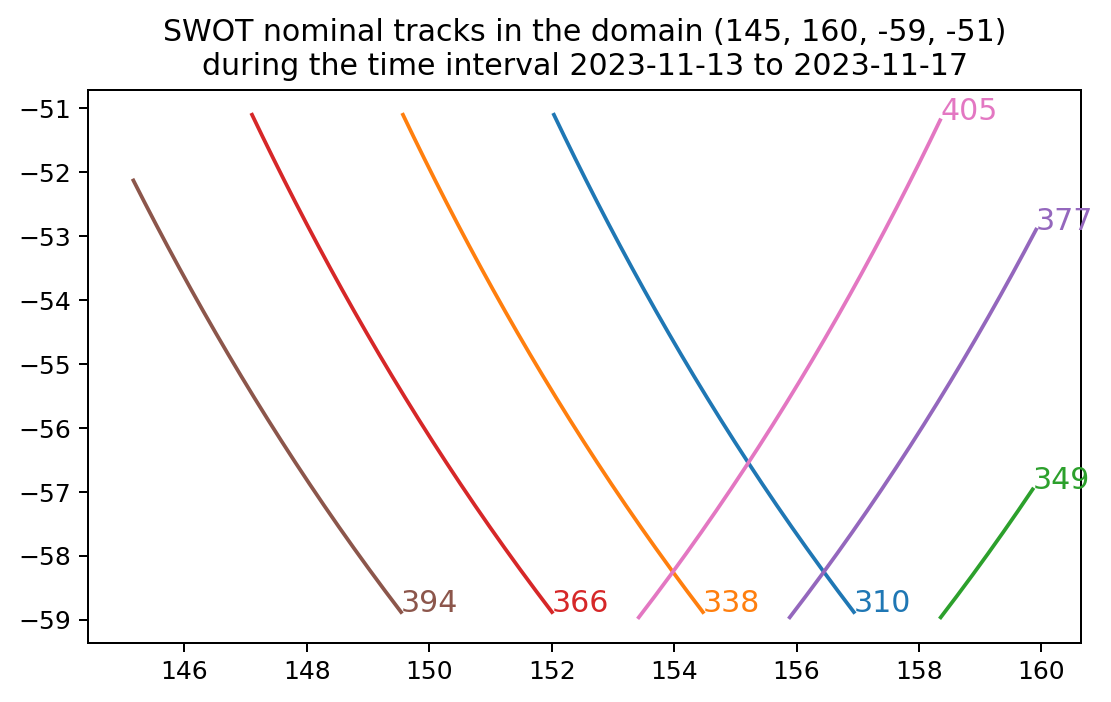

In [8]:
plt.figure(figsize = (12, 4), dpi = 180)

plt.subplot(121)
swot_tracks = sw.select_in_area(domain) # Nominal swot tracks in the domain, contain few lon/lat points to plot tracks
swot_passes = satpass.sat_pass('sw', date_range, domain) # Actual swot passes that pass in the region during the given time interval

for track in swot_passes.track:
    if track in swot_tracks.track.values:
        df = swot_tracks[swot_tracks.track == track]
        im = plt.plot(df.lon, df.lat)[0]
        c = im.get_color()
        plt.text(df.lon.values[-1], df.lat.values[-1], track, c = c, fontsize = 12)

plt.title(f'SWOT nominal tracks in the domain {domain}\nduring the time interval {date_range[0].date()} to {date_range[1].date()}')
plt.tight_layout() 

#### Exemple : application to FOCUS campaign

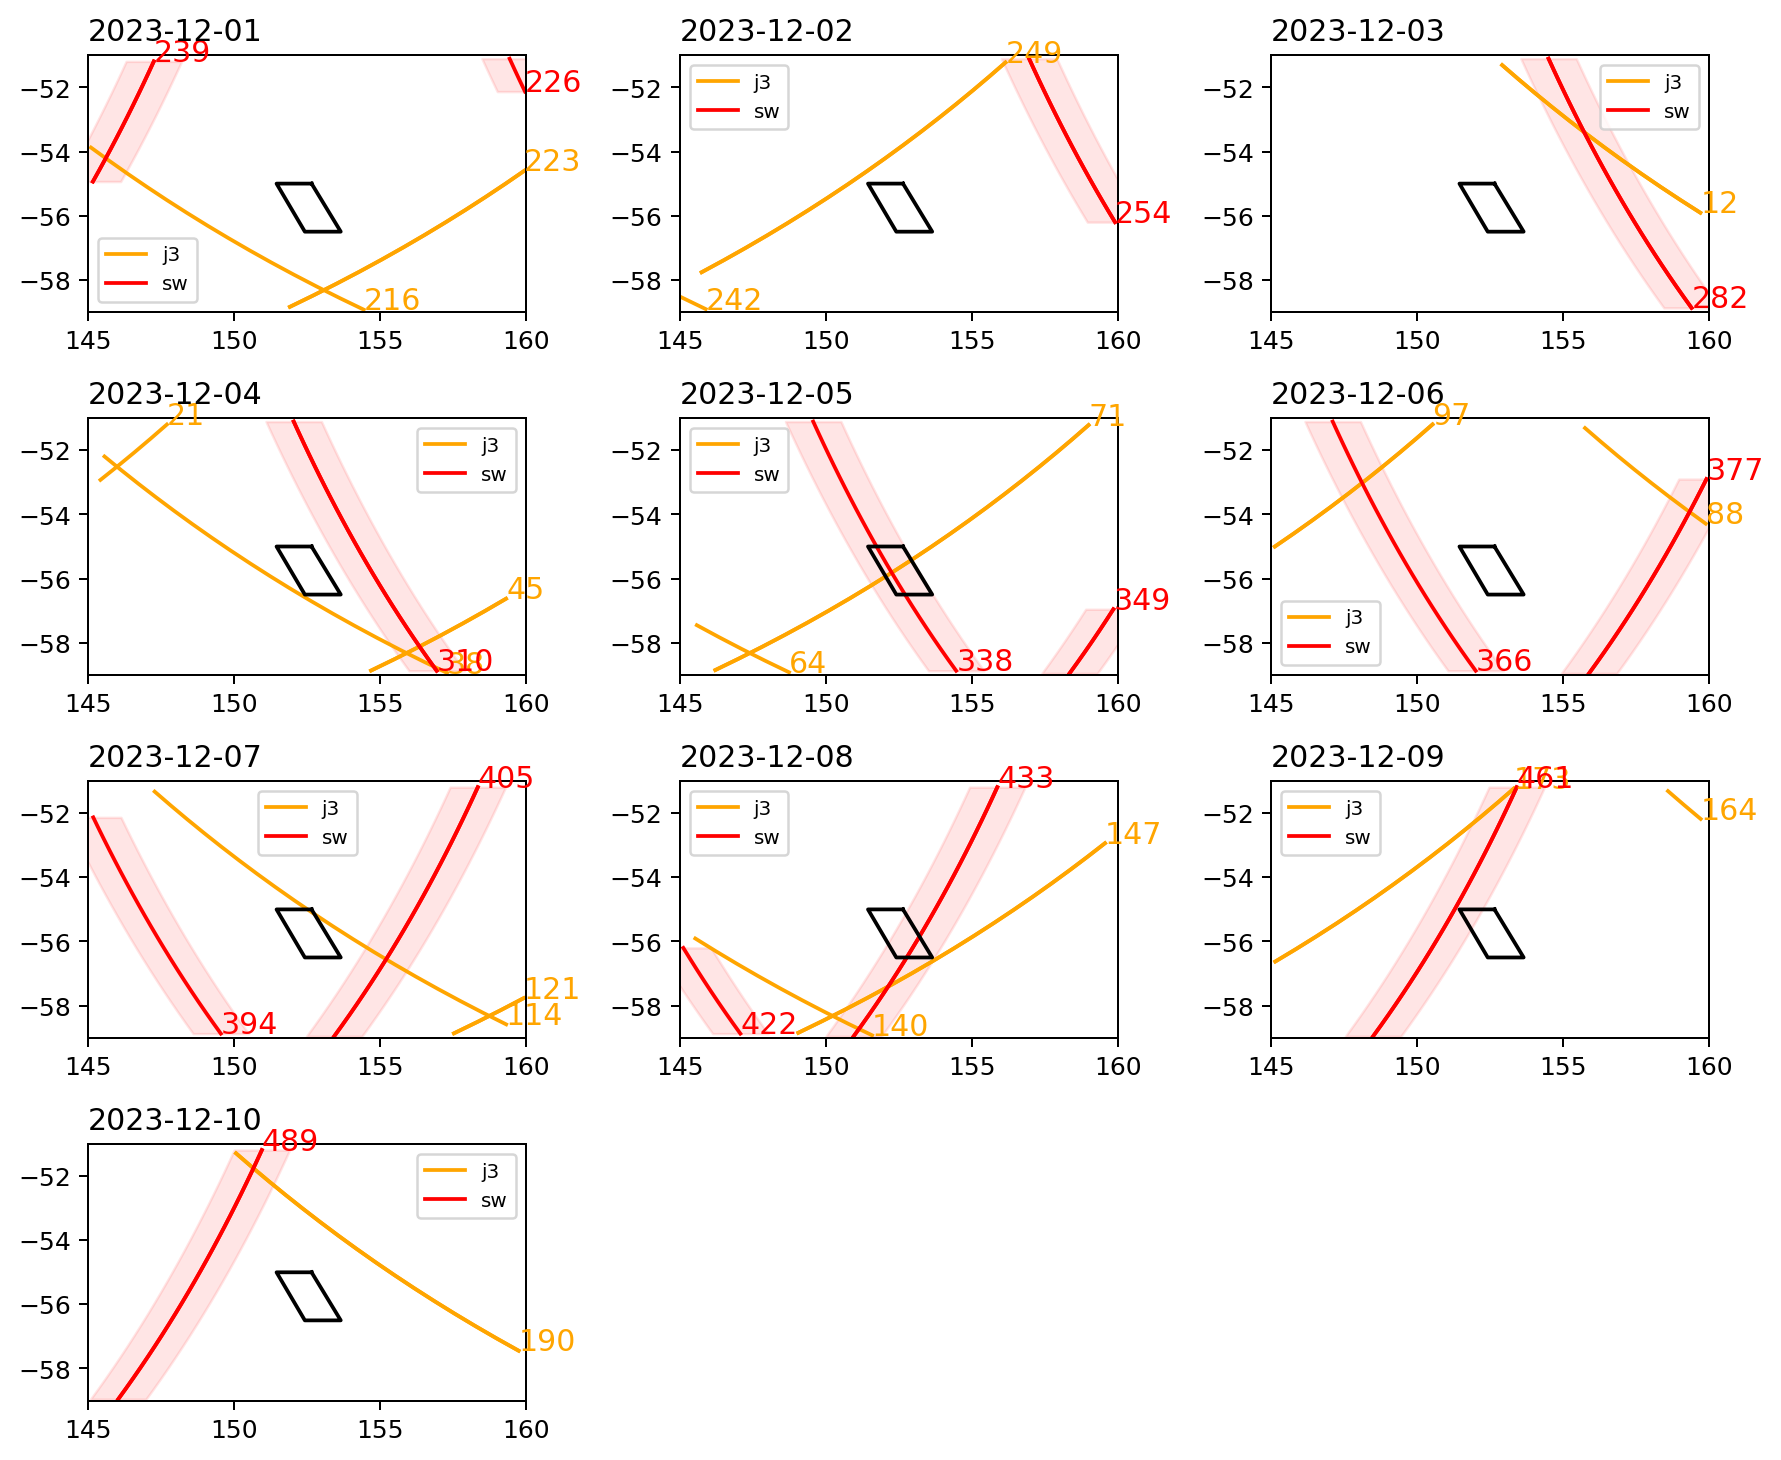

In [9]:
s3b = satpass.NominalTrack(mission='s3b')
s3a = satpass.NominalTrack(mission='s3a')
j3 = satpass.NominalTrack(mission='j3')
sw = satpass.NominalTrack(mission='sw')

date_range = pd.date_range('2023-12-01', '2023-12-10')
k = 0
colors = ['orange', 'r']

plt.figure(figsize = (10,10), dpi = 180)
for t in date_range:
    k+=1
    plt.subplot(5, int(len(date_range)/5 +1), k)
    plt.title(t.date(), loc = 'left')
    date = pd.DatetimeIndex([t, t + pd.Timedelta(hours = 24)]).tz_localize(None)
#     date_eph = pd.DatetimeIndex([pd.Timestamp(date[0]), date[1]])

    for i, m in enumerate(['j3', 'sw']):
        c = colors[i]
        nt = satpass.NominalTrack(mission=m)
        DF = satpass.sat_pass(nt, date, domain)
        tracks = nt.select_in_area(domain)
        for n in np.unique(DF.track):
            track = tracks[tracks.track == n]
            if track.any().lon:
                plt.plot(track.lon, track.lat, c = c)
                plt.text(track.lon.values[-1], track.lat.values[-1], n, c = c, fontsize = 12)
    
                if m == 'sw':
                    plt.fill_betweenx(track.lat, track.lon -0.95, track.lon +0.95, color = c, alpha = 0.1)
        plt.plot(track.lon, track.lat, c = c, label = m)
#         plt.text(track.lon.values[-1], track.lat.values[-1], n, c = c, fontsize = 12)    

#         pass
    plt.xlim(domain[:2])
    plt.ylim(domain[2:])
    plt.plot(waypoints[0], waypoints[1], c = 'k')
    plt.legend(fontsize = 8)
    
plt.tight_layout()

#### Exemple : Application to SWOT ascending/descending subcycles (4 per 21 days cycle)

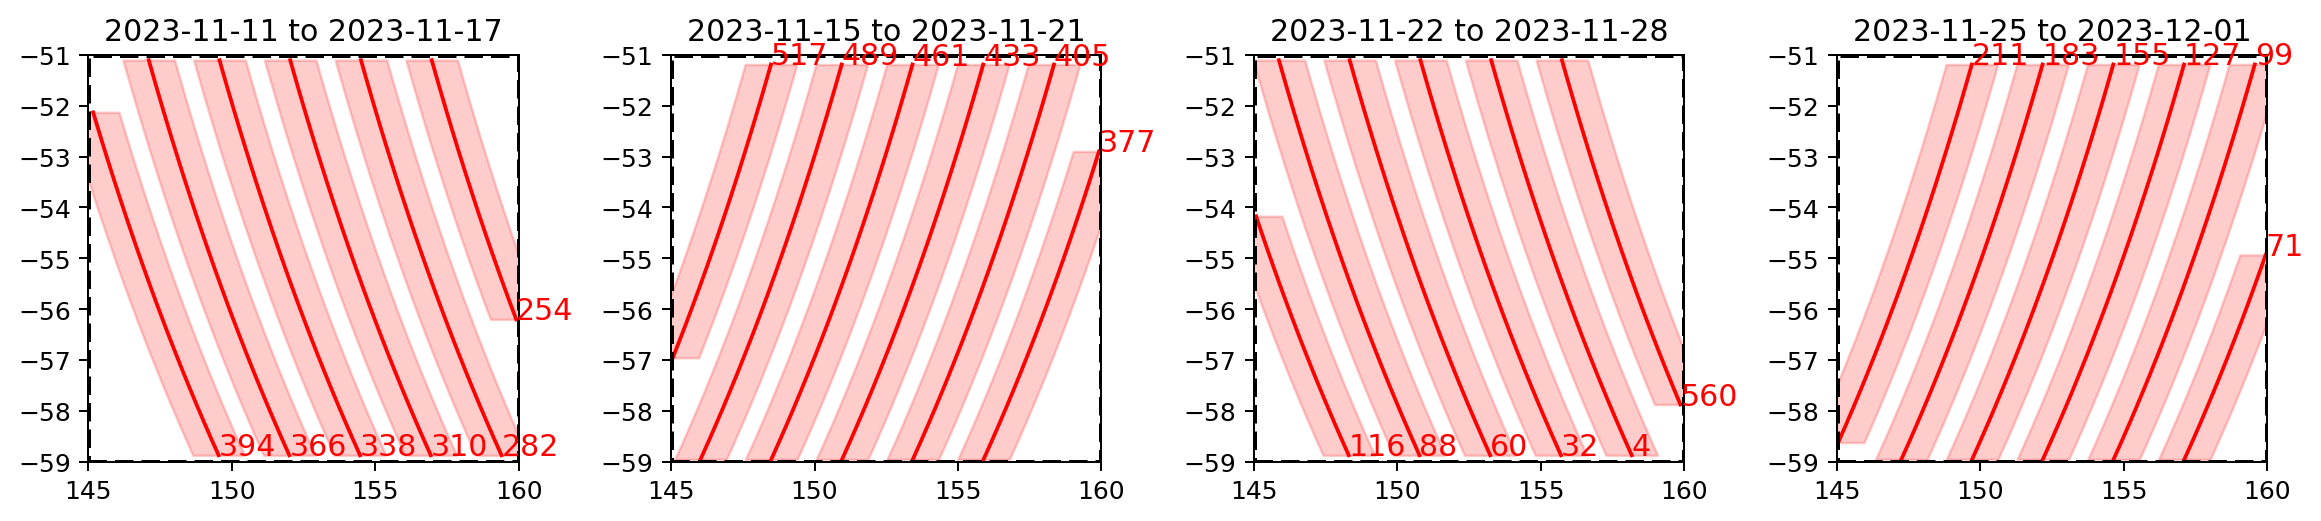

In [10]:
nt = sw

plt.figure(figsize = (13,3), dpi = 180)

date_range = [pd.Timestamp('2023-11-11'), pd.Timestamp('2023-11-17')]
plt.subplot(141)
DF = satpass.sat_pass(nt, date_range, domain)
DF = DF[DF.direction == 'des']

n_tracks, dct = nt.get_tracks(area = domain)
for track in np.unique(DF.track):
    x, y, dt = np.array(dct[track]).T
    plt.plot(x, y, c = 'r')
    plt.fill_betweenx((y).astype(float), (x).astype(float) - 0.9,(x).astype(float)+0.9, color = 'r', alpha = 0.2)
    plt.text(x[-1], y[-1], track, c = 'r', fontsize = 12)

plt.title(f'{date_range[0].date()} to {date_range[1].date()}')
plt.plot(x_domain, y_domain, lw = 2, c = 'k', ls = '--')
plt.xlim(domain[:2])
plt.ylim(domain[2:])

############

date_range = [pd.Timestamp('2023-11-15'), pd.Timestamp('2023-11-21')]
plt.subplot(142)
DF = satpass.sat_pass(nt, date_range, domain)
DF = DF[DF.direction == 'asc']

n_tracks, dct = nt.get_tracks(area = domain)
for track in np.unique(DF.track):
    x, y, dt = np.array(dct[track]).T
    plt.plot(x, y, c = 'r')
    plt.fill_betweenx((y).astype(float), (x).astype(float) - 0.9,(x).astype(float)+0.9, color = 'r', alpha = 0.2)
    plt.text(x[-1], y[-1], track, c = 'r', fontsize = 12)

plt.title(f'{date_range[0].date()} to {date_range[1].date()}')
plt.plot(x_domain, y_domain, lw = 2, c = 'k', ls = '--')
plt.xlim(domain[:2])
plt.ylim(domain[2:])

##############

date_range = [pd.Timestamp('2023-11-22'), pd.Timestamp('2023-11-28')]
plt.subplot(143)
DF = satpass.sat_pass(nt, date_range, domain)
DF = DF[DF.direction == 'des']

n_tracks, dct = nt.get_tracks(area = domain)
for track in np.unique(DF.track):
    x, y, dt = np.array(dct[track]).T
    plt.plot(x, y, c = 'r')
    plt.fill_betweenx((y).astype(float), (x).astype(float) - 0.9,(x).astype(float)+0.9, color = 'r', alpha = 0.2)
    plt.text(x[-1], y[-1], track, c = 'r', fontsize = 12)

plt.title(f'{date_range[0].date()} to {date_range[1].date()}')
plt.plot(x_domain, y_domain, lw = 2, c = 'k', ls = '--')
plt.xlim(domain[:2])
plt.ylim(domain[2:])

#############

date_range = [pd.Timestamp('2023-11-25'), pd.Timestamp('2023-12-01')]
plt.subplot(144)
DF = satpass.sat_pass(nt, date_range, domain)
DF = DF[DF.direction == 'asc']
n_tracks, dct = nt.get_tracks(area = domain)
for track in np.unique(DF.track):
    x, y, dt = np.array(dct[track]).T
    plt.plot(x, y, c = 'r')
    plt.fill_betweenx((y).astype(float), (x).astype(float) - 0.9,(x).astype(float)+0.9, color = 'r', alpha = 0.2)
    plt.text(x[-1], y[-1], track, c = 'r', fontsize = 12)

plt.title(f'{date_range[0].date()} to {date_range[1].date()}')
plt.plot(x_domain, y_domain, lw = 2, c = 'k', ls = '--')
plt.xlim(domain[:2])
plt.ylim(domain[2:])

plt.tight_layout()